* * *
<pre> NYU Paris            <i> Machine Learning - Sumer 2023 </i></pre>
* * *


<h1 align="center"> Lab Unsupervised learning: clustering </h1>

<pre align="left"> June 08th 2023               <i> Author: Guillaume Staerman </i></pre>
* * *


##### Goals:
- More practice with numpy and matplotlib
- Understand the pros and cons of K-means clustering, hierarchical clustering and GMM

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

seed = 42

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# Speed up PyTorch data loading
torch.set_num_threads(2)  # Reduce CPU overhead
%matplotlib inline

# Part 1: Implementing K-means

In the past labs, we have mainly seen:
- dimension reduction (with PCA)
- classification (i.e supervised learning)

In practice however, the vast majority of data does not have labels. Finding structure and patterns in data without labels is called unsupervised learning. Given a specified number of clusters K, the K-means algorithm forms a partition of your data with K different groups while trying to:
- minimize the variance within groups (i.e samples forming a group must be close to each other)
- maximize the variance between groups (i.e groups must be far from each other).

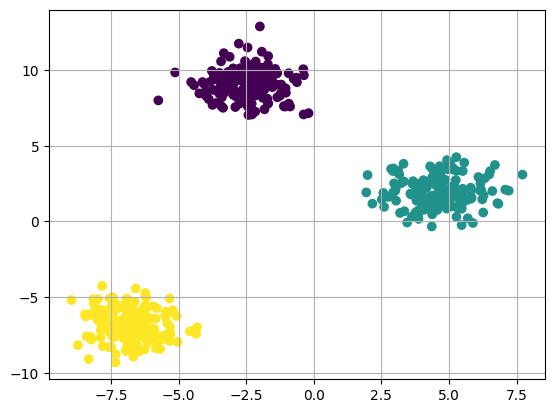

In [5]:
from sklearn.datasets import make_blobs

X, y = make_blobs(500, centers=3, n_features=2, cluster_std=1., random_state=seed)

plt.figure()
plt.grid()
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()


In [6]:
# print(X)
max_x_coordinate = max(X[:,0])
max_y_coordinate= max(X[:,1])
min_x_coordinate = min(X[:,0])
min_y_coordinate= min(X[:,1])
print(max_x_coordinate,max_y_coordinate,min_x_coordinate,min_y_coordinate)

7.718759644683339 12.867017618853042 -8.961556599034992 -9.303988919904903


It is called K-means because it only consists of two steps. Starting from an initialization of K mean values $M_k$:
- For each sample $x$ of your data, find the mean (centroid) $C_k$ that is closest to x. Assign $x$ to group $k$.
- Update the mean $C_k$ of each group k

### Question 1
Write a function that generates K random initializations for the group centroids $C_k$.

In [7]:
np.random.uniform(1,5,size = 4)

array([4.12329991, 1.42036605, 1.88170792, 4.74578623])

In [8]:
def init_centroids(K, dimension=2):
    min_value = -2
    max_value = 2
    centroid = []
    for i in range(K):
        centroid.append(np.random.uniform(min_value,max_value,size=dimension))

    return np.array(centroid)
    #returns a list of 2-d coordinates

### Question 2
Write a function that takes the data X (n, d) and returns an array (n,) containing the id of the cluster it should be assigned to. For example, the function returns [0, 0, 2, 1, 2] if the first two samples are assigned to cluster 0, the 3rd and 5th samples to cluster 2 and the 4th sample to cluster 1.

_Hint: look up `sklearn.metrics.pairwise_distances` and the numpy method of an array `array.argmin`_

In [9]:
from sklearn.metrics.pairwise import pairwise_distances

In [10]:
def assign_labels(X, centroids):
    labels = np.argmin(pairwise_distances(X,centroids),axis = 1)
    # print(labels)
    return np.array(labels)

In [11]:
# assign_labels(X,centroids)

In [12]:
# labels

### Question 3
The following cell visualizes the centroids and their assigned samples. Initialize the centroids and compute a first set of labels of your data and visualize them. Can you think of a smarter way to initialize these centroids using the data? (No need to implement it for now).

In [13]:
def plot_kmeans(X, labels, centroids):
    K = len(centroids)
    colors = np.array(cm.Set1(np.linspace(0., 1, K)))
    plt.figure()
    plt.grid()
    plt.scatter(X[:, 0], X[:, 1], color=colors[labels], s=4, alpha=0.3)
    plt.scatter(centroids[:, 0], centroids[:, 1], color=colors, marker="^", s=100)
    plt.show()


In [14]:
centroids = init_centroids(3)
labels = assign_labels(X,centroids)

In [15]:
centroids

array([[ 0.22901497,  0.60886957],
       [-0.5166418 ,  1.63229745],
       [ 0.89801759, -0.59263539]])

In [16]:
# for i in range(len(X)):
#     print(X[i],labels[i])
print(np.sum(assign_labels(X,centroids)==0),

np.sum(assign_labels(X,centroids)==1),

np.sum(assign_labels(X,centroids)==2))

60 173 267


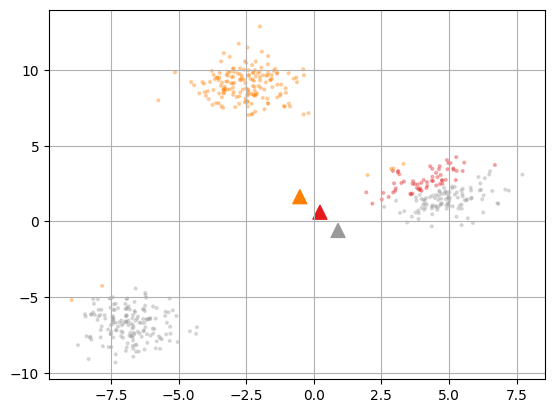

[[ 0.22901497  0.60886957]
 [-0.5166418   1.63229745]
 [ 0.89801759 -0.59263539]]
[ 0.22901497 -0.5166418   0.89801759]


In [17]:
plot_kmeans(X,labels,centroids)
print(centroids)
print(centroids[:,0])

### Question 4
Write a function that computes the new centroids using the assigned labels. Visualize the new centroids. Repeat these steps (label assignment + centroid update) for 2-3 steps. Does it converge?

In [18]:

def update_centroids(X, labels, centroids):
    # Number of clusters (K)
    K = centroids.shape[0]

    # Initialize an array to store the updated centroids
    new_centroids = np.zeros_like(centroids)

    # To count the number of points in each cluster
    counts = np.zeros(K)

    # Sum up the points for each cluster
    for k in range(K):
        points_in_cluster = X[labels == k]
        counts[k] = len(points_in_cluster)

        # If there are any points in this cluster, update the centroid
        if counts[k] > 0:
            new_centroids[k] = np.mean(points_in_cluster, axis=0)
        else:
            min_value, max_value = np.min(X),np.max(X)
            dimension = X.shape[1]
            # Handle empty clusters: reinitialize centroid
            new_centroids[k] = np.random.uniform(min_value,max_value,size=dimension)
    return new_centroids


In [19]:
def update_and_label(X,labels,centroids,i):
    for j in range(i):
        centroids_prev = centroids
        centroids = update_centroids(X,labels,centroids)
        labels = assign_labels(X,centroids)
        plot_kmeans(X, labels, centroids)




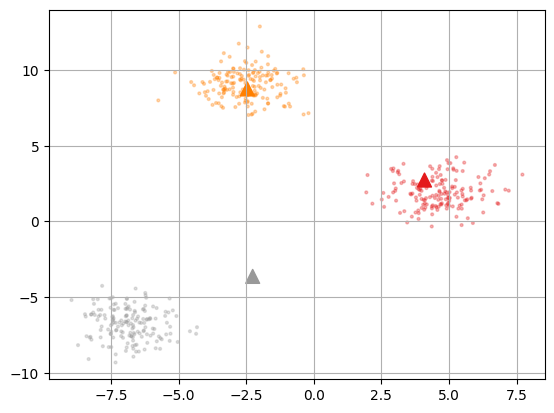

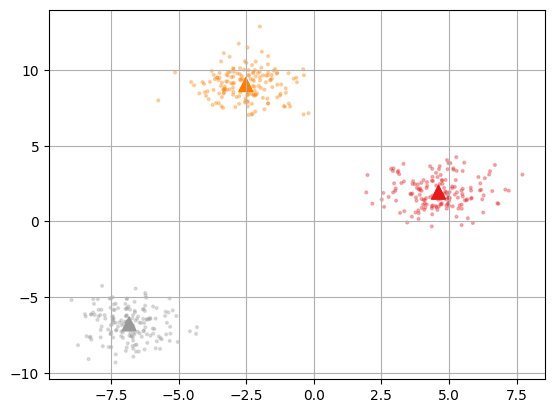

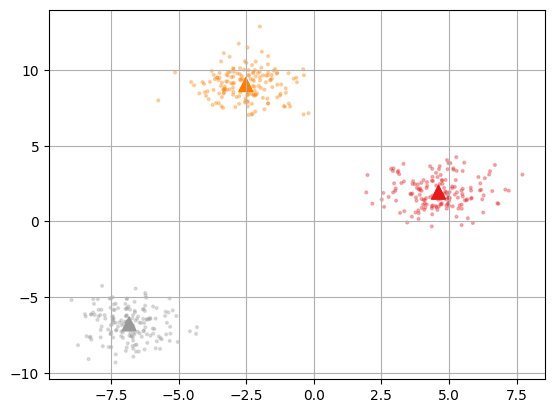

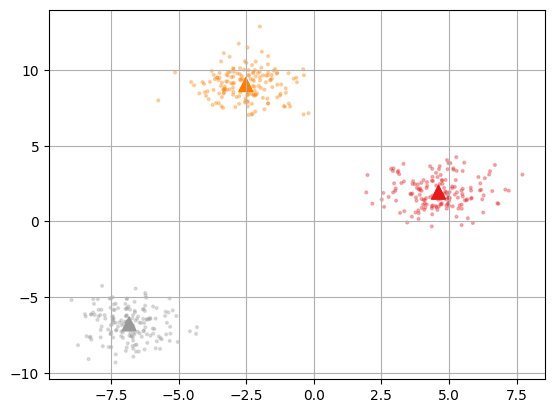

In [20]:
update_and_label(X,labels,centroids,4)


The steps converge

### Question 5
The K-means algorithm repeats these operations until the centroids stop changing. Write a function summing up all these operations.

In [21]:

def Kmeans_(X, K=3, maxiter=100, threshold=1, plot_steps=False):
    dimension = X.shape[1]

    # Initialization step
    centroids = init_centroids(K,dimension)
    # print(centroids)
    labels = assign_labels(X, centroids)

    # Initialize SSE
    sse_prev = np.inf  # Start with a very large value

    for ii in range(maxiter):
        # K-means 2 steps: Update centroids and assign labels
        centroids_prev = centroids
        centroids = update_centroids(X, labels, centroids)
        labels = assign_labels(X, centroids)

        # Compute the Sum of Squared Errors (SSE)
        sse = np.sum(np.min(pairwise_distances(X, centroids)**2, axis=1))

        # Check if the change in SSE is below the threshold to stop
        if np.abs(sse_prev - sse) < threshold:
            break

        # Update the previous SSE value
        sse_prev = sse

        # Optional: Plot the steps
        if plot_steps:
            plot_kmeans(X, labels, centroids)

    return labels, centroids



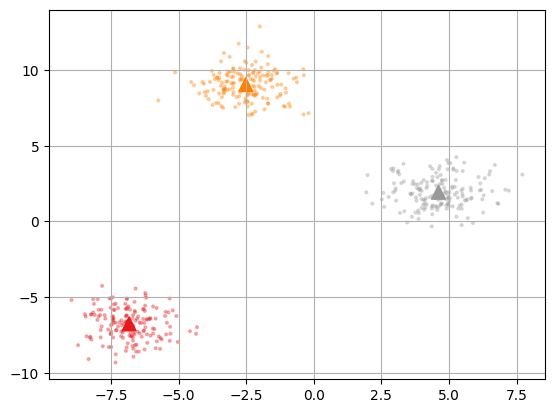

In [22]:
label1,centroid1 = Kmeans_(X)
plot_kmeans(X,label1,centroid1)

### Question 6

Generate different sets of data examples (changing the `cluster_std` parameter) and visualize the K-means output. What do you notice?

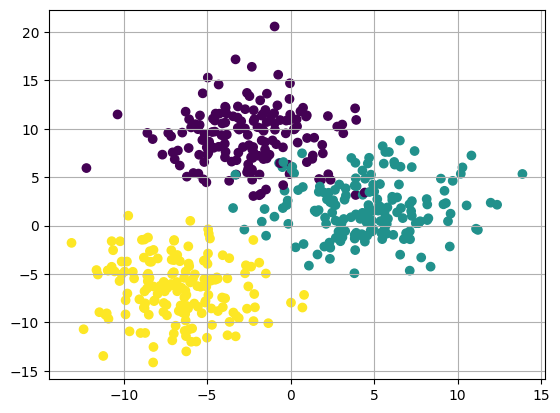

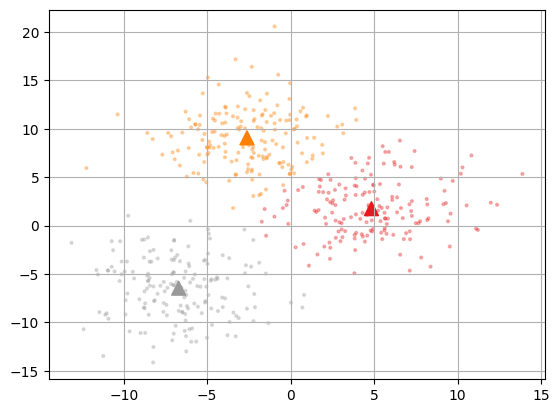

In [23]:

# def different_data(cluster_std_val):
X1, y1 = make_blobs(500, centers=3, n_features=2, cluster_std=3, random_state=seed)

plt.figure()
plt.grid()
plt.scatter(X1[:, 0], X1[:, 1], c=y1)
plt.show()
label2,centroid2 = Kmeans_(X1)
plot_kmeans(X1,label2,centroid2)




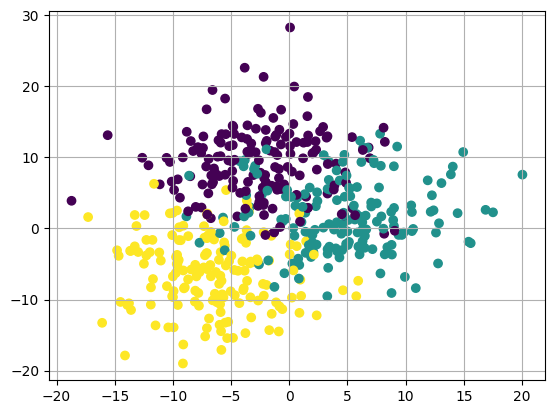

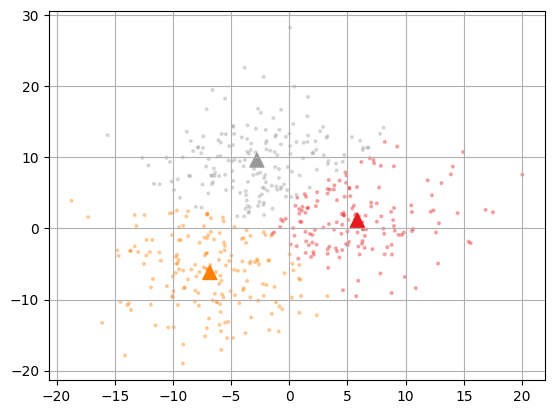

In [24]:
X1, y1 = make_blobs(500, centers=3, n_features=2, cluster_std=5, random_state=seed)

plt.figure()
plt.grid()
plt.scatter(X1[:, 0], X1[:, 1], c=y1)
plt.show()
l11,c11 = Kmeans_(X1)
plot_kmeans(X1,l11,c11)

### Question 7
Try Kmeans with this new data. Choose K wisely. Is it normal that Kmeans fails?

In [25]:
from sklearn.datasets import make_circles

X, y = make_circles(500, noise=0.1, factor=0.2)


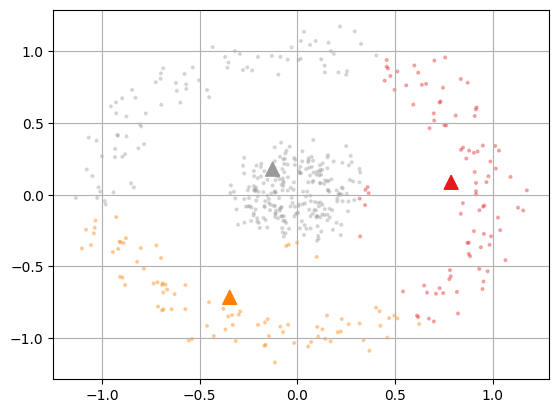

In [26]:
label1,centroid1 = Kmeans_(X)
plot_kmeans(X,label1,centroid1)


# Part 2: Compressing images with K-means
Is it often the case that data is redundant. Take the example of the image below:

Image original shape:  (427, 640, 3)
Flower colors shape:  (273280, 3)


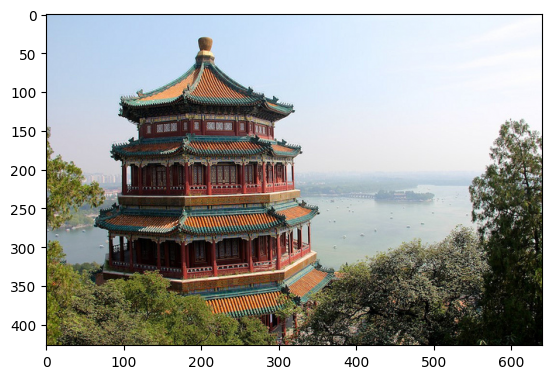

In [27]:
from sklearn.datasets import load_sample_image

flower = load_sample_image('china.jpg') / 255
flower_shape = flower.shape
flower_colors = flower.reshape(-1, 3)


print("Image original shape: ", flower_shape)
print("Flower colors shape: ", flower_colors.shape)

max_color = flower.max()

plt.figure()
plt.imshow(flower)
plt.show()

In [28]:
flower.shape
# flower_colors.shape[0]

(427, 640, 3)

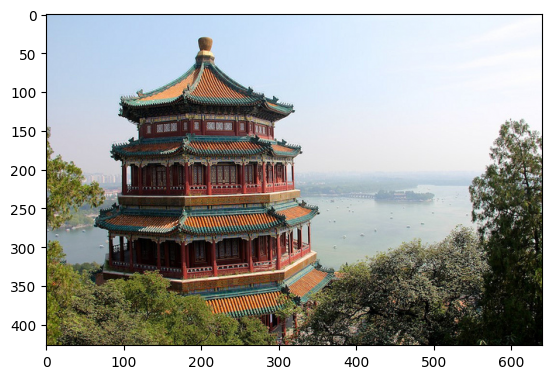

In [29]:
plt.imshow(flower)

### Question 8
We would like to replace all colors by replacing them with the centroid they're closest to. Let's for example reduce them to 16. Run the Kmeans algorithm with K=16 on the downsampled colors array X. Then create a new image with the replaced colors and visualize it.

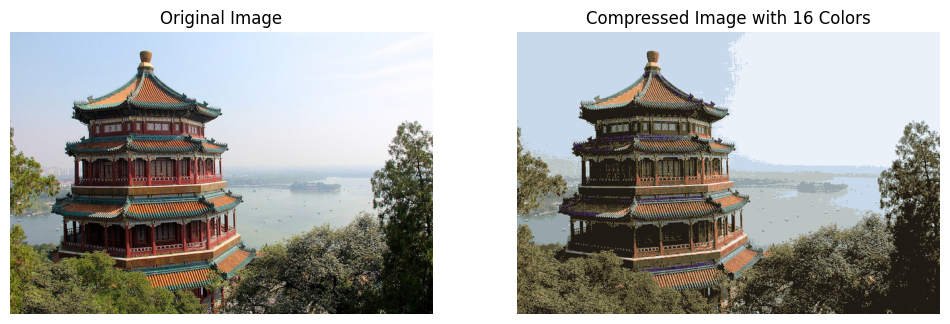

In [30]:
from sklearn.utils import shuffle
from sklearn.cluster import KMeans

def Compressor(image,K):
    image_reshaped = image.reshape(-1, 3)
    X = shuffle(image_reshaped, random_state=0, n_samples=1_000)
    labels, centroids = Kmeans_(X, K=K)
    # print(labels,centroids)

    # Assign each pixel to its nearest cluster center

    full_labels = assign_labels(image_reshaped, centroids)

    # Reconstruct the compressed image using centroids
    compressed_image = centroids[full_labels].reshape(image.shape)

    # Display original and compressed images
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(flower)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(compressed_image)
    ax[1].set_title(f"Compressed Image with {K} Colors")
    ax[1].axis("off")

    plt.show()


Compressor(flower,16)



In [31]:
flower_colors.shape
type(flower_colors)

numpy.ndarray

### Question 9
Play around with the value of n_clusters (K). What do you notice?

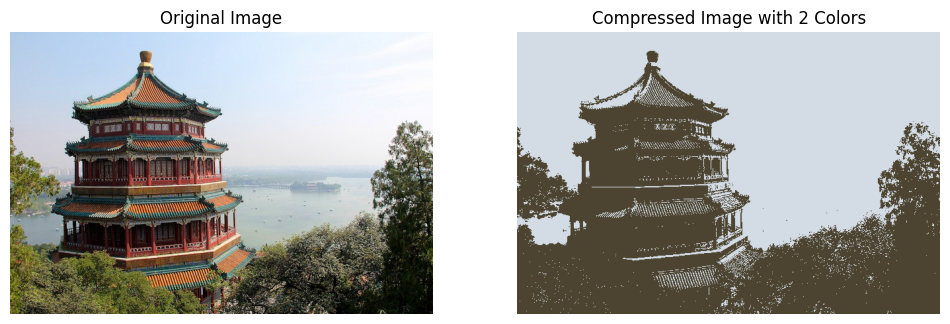

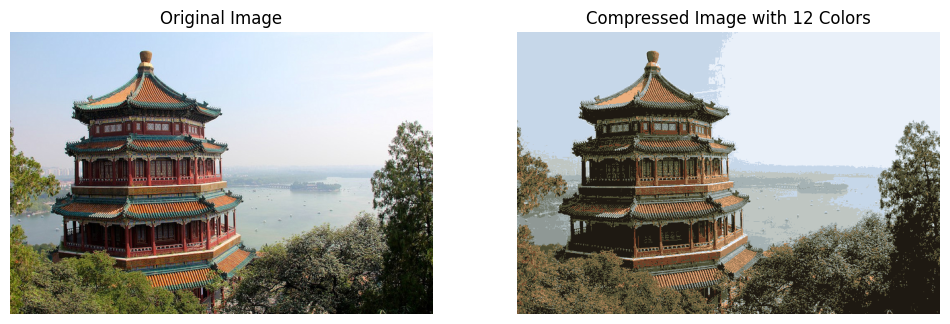

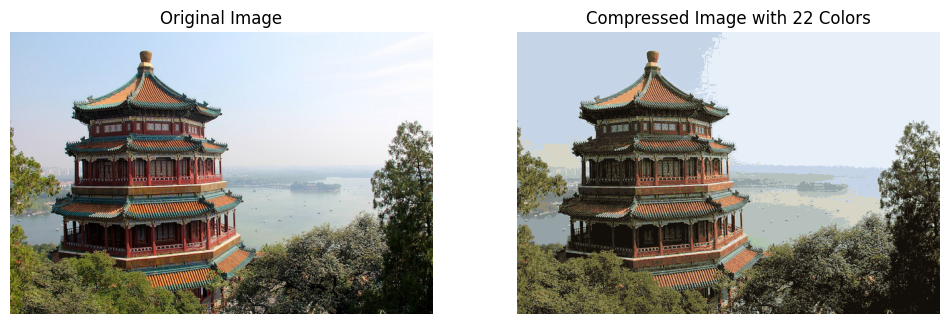

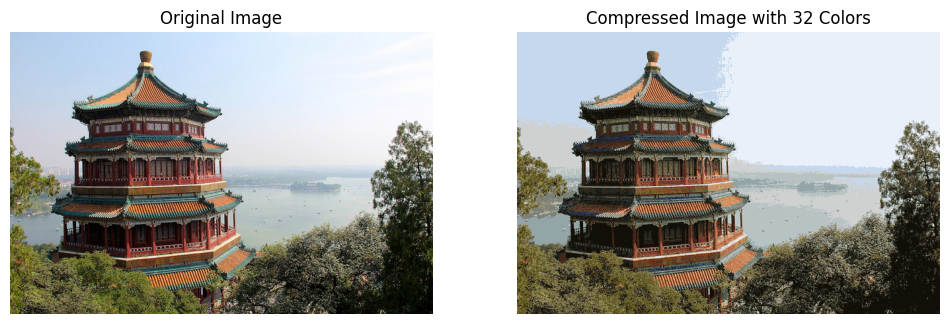

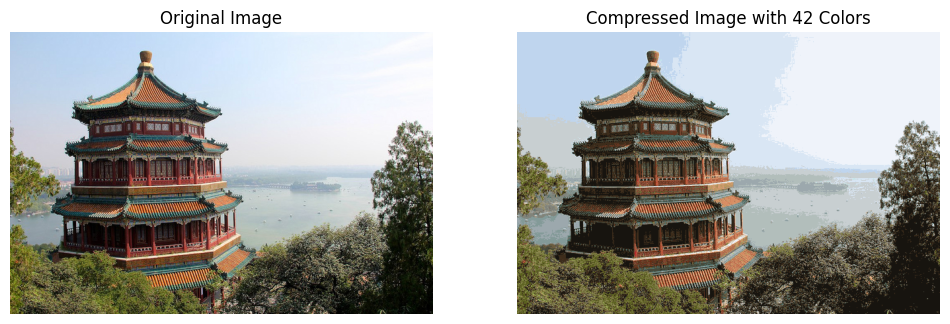

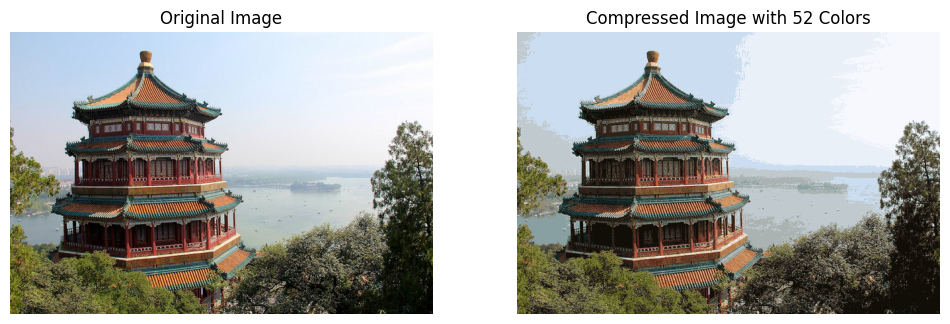

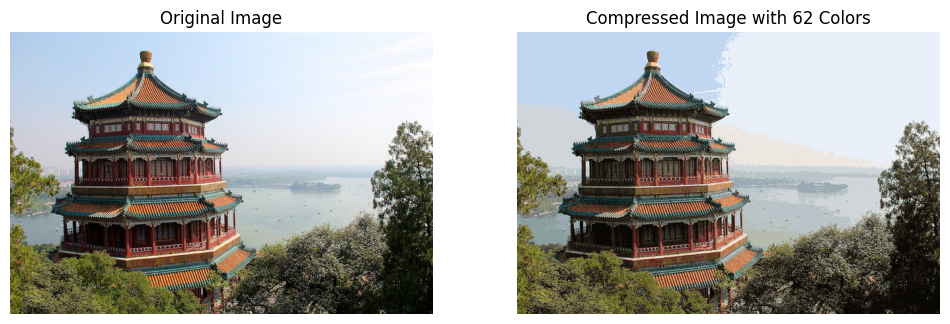

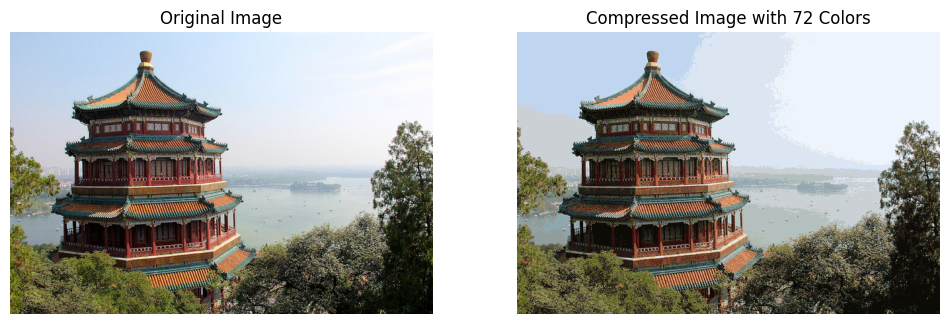

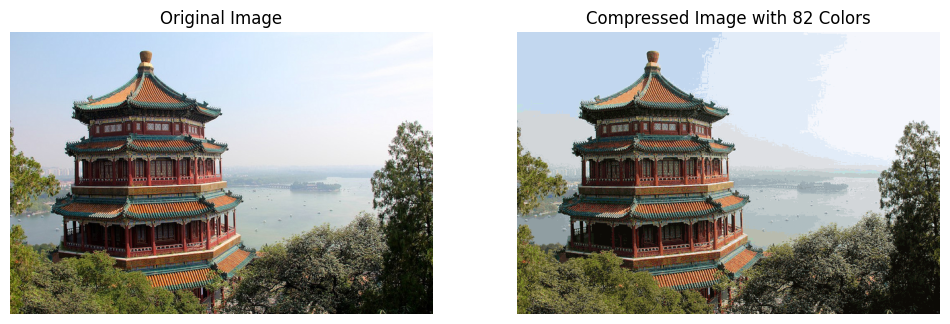

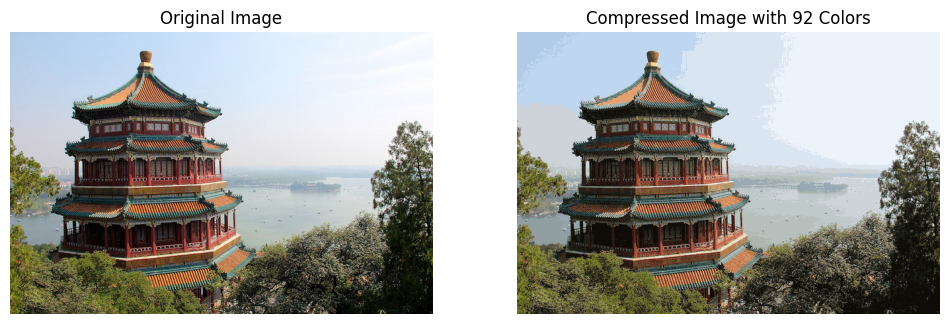

In [32]:

for i in range(2,100,10):
    Compressor(flower,i)


### Question 10
Try this out but using the sklearn implementation of Kmeans. Do you obtain similar results? Can you explain the difference?

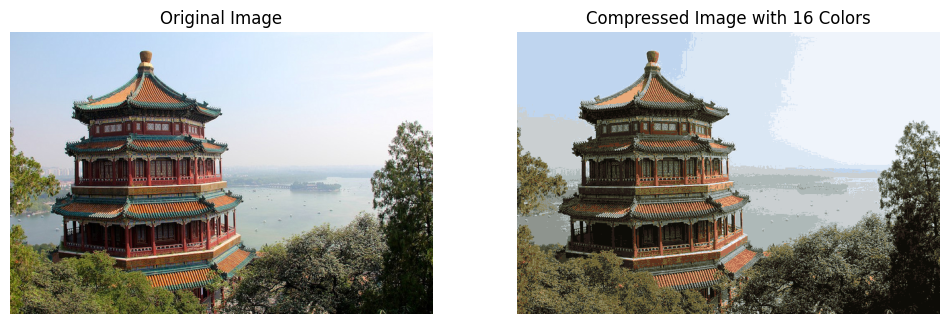

In [33]:
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# Step 1: Shuffle to sample from the image for faster training
n_colors = 16
image_sample = shuffle(flower_colors, random_state=0, n_samples=1000)

# Step 2: Fit KMeans
kmeans = KMeans(n_clusters=n_colors, n_init='auto', random_state=0)
kmeans.fit(image_sample)

# Step 3: Predict cluster for all pixels in original image
full_labels = kmeans.predict(flower_colors)

# Step 4: Replace each pixel by its centroid color
compressed_image = kmeans.cluster_centers_[full_labels].reshape(flower_shape)

# Step 5: Plot the original and compressed images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(flower)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(compressed_image)
ax[1].set_title(f"Compressed Image with {n_colors} Colors")
ax[1].axis("off")

plt.show()


There is not much difference when I compare my implementation to that of the sklearn implementation of Kmeans

# Part 3: Implementing  Hierarchical clustering


## Question 11

Implement a function that compute the distance matrix between data. The parameter 'distance' define the chosen distance on the Euclidean space. You can use functions from scipy or sklearn. Implement three distances of your choice.

In [34]:
def distance_matrix(X, distance='euclidean'):
    matrix= pairwise_distances(X, metric='euclidean')
    return matrix

## Question 12

Implement diffent similarity functions between clusters that you have seen in class (Linkage slide). Regarding the question 13, find a clever way to implement cluster variable (cluster1, cluster2).

In [35]:
def cluster_similarity(cluster1, cluster2, X, linkage):

    C1 = X[cluster1]
    C2 = X[cluster2]

    if linkage == 'single':
        return np.min(pairwise_distances(C1, C2))
    elif linkage == 'complete':
        return np.max(pairwise_distances(C1, C2))
    elif linkage == 'average':
        return np.mean(pairwise_distances(C1, C2))
    elif linkage == 'centroid':
        centroid1 = np.mean(C1, axis=0)
        centroid2 = np.mean(C2, axis=0)
        return np.linalg.norm(centroid1 - centroid2)
    else:
        raise ValueError(f"Unknown linkage type: {linkage}")

## Question 13

Implement a function that performs Agglomerative Hierarchical Clustering.

In [36]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [37]:
def agglo_hier_clust(X, linkage='single'):
    n_samples = X.shape[0]
    clusters = [[i] for i in range(n_samples)]
    cluster_sizes = [1] * n_samples
    next_id = n_samples  # Next available cluster ID
    Z = []

    # We need to track which original clusters have been merged
    cluster_id_map = {i: i for i in range(n_samples)}

    while len(clusters) > 1:
        min_distance = np.inf
        closest_clusters = None

        # Find the two closest clusters
        for i in range(len(clusters)):
            for j in range(i+1, len(clusters)):
                dist = cluster_similarity(clusters[i], clusters[j], X, linkage)
                if dist < min_distance:
                    min_distance = dist
                    closest_clusters = (i, j)

        i, j = closest_clusters

        # Get the current IDs of the clusters to be merged
        id_i = cluster_id_map[clusters[i][0]]
        id_j = cluster_id_map[clusters[j][0]]

        # Record the merge
        Z.append([id_i, id_j, min_distance, len(clusters[i]) + len(clusters[j])])

        # Merge clusters
        new_cluster = clusters[i] + clusters[j]
        clusters[i] = new_cluster
        del clusters[j]

        # Update the ID mapping for the new cluster
        for point in new_cluster:
            cluster_id_map[point] = next_id
        next_id += 1

    return np.array(Z)

def plot_dendrogram_and_2d(X, linkage='single'):
    Z = agglo_hier_clust(X, linkage)

    # Plot points
    plt.figure(figsize=(12, 7))
    plt.scatter(X[:, 0], X[:, 1], c='blue', s=50, marker='o')
    for i, (x, y) in enumerate(X):
        plt.text(x, y, str(i), ha='center', va='bottom')
    plt.title('2D Points')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.show()

    # Plot dendrogram
    plt.figure(figsize=(10, 7))
    dendrogram(Z, labels=[str(i) for i in range(len(X))])
    plt.title(f"Dendrogram using {linkage.capitalize()} Linkage")
    plt.xlabel("Sample Index")
    plt.ylabel("Distance")
    plt.show()


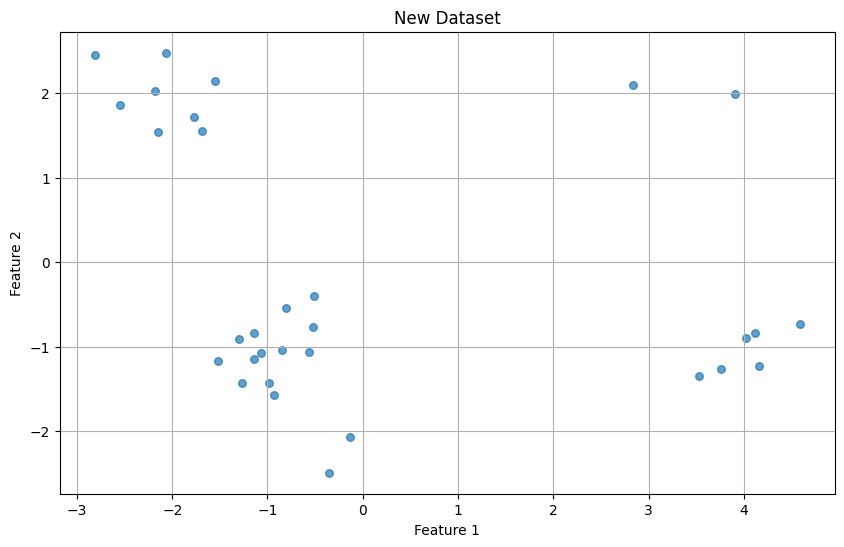

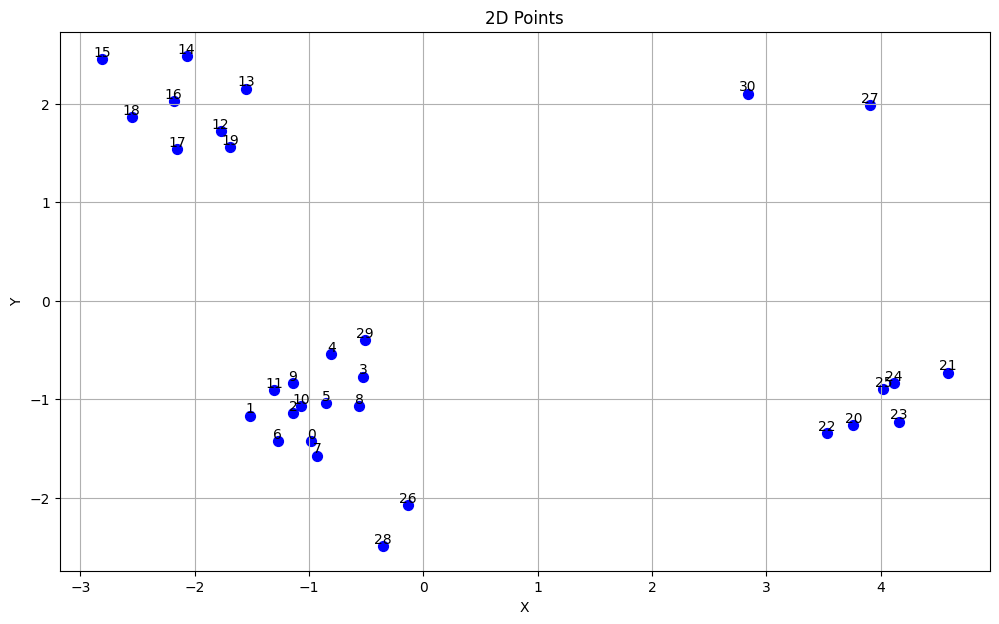

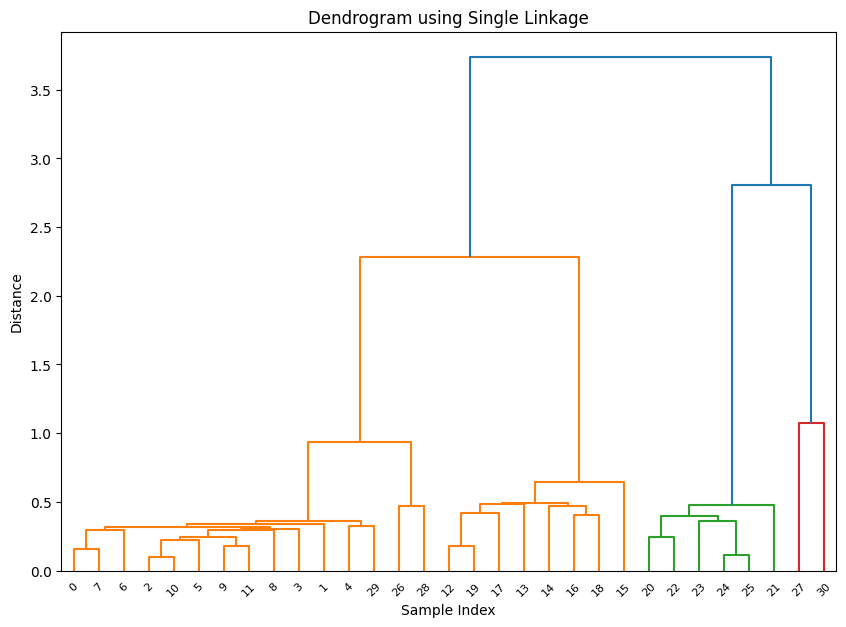

In [38]:
def new_dataset(n_samples=25, random_state=42):
    np.random.seed(random_state)
    # Three Gaussian blobs
    blobs1, _ = make_blobs(n_samples=n_samples//2, centers=[[-1, -1]], cluster_std=0.3)
    blobs2, _ = make_blobs(n_samples=n_samples//3, centers=[[-2, 2]], cluster_std=0.4)
    blobs3, _ = make_blobs(n_samples=n_samples//4, centers=[[4, -1]], cluster_std=0.25)

    # Some random noise
    noise = np.random.uniform(low=-3, high=5, size=(n_samples//5, 2))

    X = np.vstack([ blobs1, blobs2, blobs3, noise])

    return X

# Generate and visualize the dataset
X = new_dataset()
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], s=30, alpha=0.7)
plt.title("New Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()
plot_dendrogram_and_2d(X, linkage='single')

## Question 14 (Bonus)

Implement a function that performs Divisive Hierarchical Clustering.

In [39]:
def divisive_hier_clust(X, linkage='complete', threshold=1.0):

    def cluster_diameter(cluster_indices):
        if len(cluster_indices) <= 1:
            return 0.0

        sub_X = X[cluster_indices]
        distances = pairwise_distances(sub_X)

        if linkage == 'single':
            return np.min(distances[np.triu_indices_from(distances, k=1)])
        elif linkage == 'complete':
            return np.max(distances[np.triu_indices_from(distances, k=1)])
        elif linkage == 'average':
            return np.mean(distances[np.triu_indices_from(distances, k=1)])
        elif linkage == 'centroid':
            centroid = np.mean(sub_X, axis=0)
            return np.max(np.linalg.norm(sub_X - centroid, axis=1))

    # Initialize with one cluster containing all points
    clusters = [np.arange(len(X))]
    final_labels = np.zeros(len(X))

    changed = True

    while changed:
        changed = False
        new_clusters = []

        for cluster in clusters:
            if len(cluster) <= 1:
                new_clusters.append(cluster)
                continue

            diameter = cluster_diameter(cluster)

            if diameter > threshold:
                # Split the cluster using KMeans with explicit n_init
                kmeans = KMeans(n_clusters=2, n_init=10, random_state=42).fit(X[cluster])
                split1 = cluster[kmeans.labels_ == 0]
                split2 = cluster[kmeans.labels_ == 1]

                if len(split1) > 0 and len(split2) > 0:  # Only split if we get two clusters
                    new_clusters.extend([split1, split2])
                    changed = True
                else:
                    new_clusters.append(cluster)
            else:
                new_clusters.append(cluster)

        clusters = new_clusters

    # Convert cluster indices to labels
    for i, cluster in enumerate(clusters):
        final_labels[cluster] = i

    return final_labels

## Question 15

Apply this (or these) algorithm(s) on the Gaussian blobs

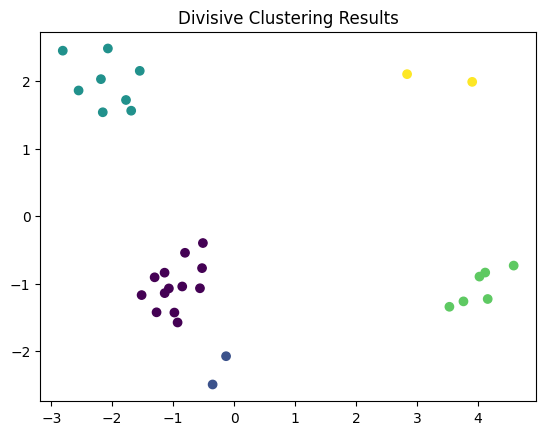

In [40]:
X = new_dataset()
# Perform divisive clustering
labels = divisive_hier_clust(X, linkage='complete', threshold=1.5)
# print(labels)

# Visualize
plt.scatter(X[:,0], X[:,1], c=labels, cmap='viridis')
plt.title("Divisive Clustering Results")
plt.show()

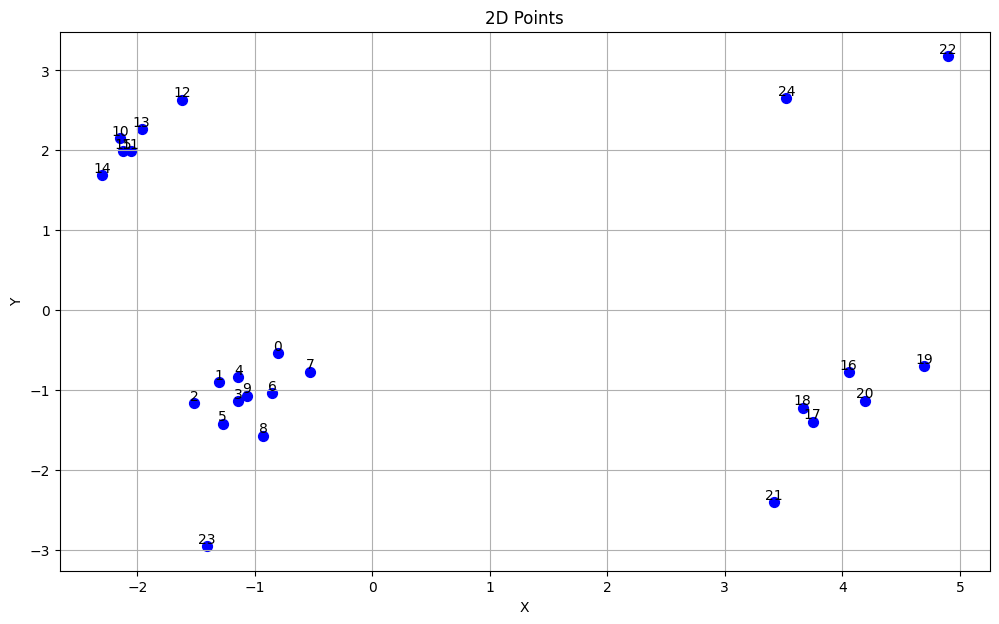

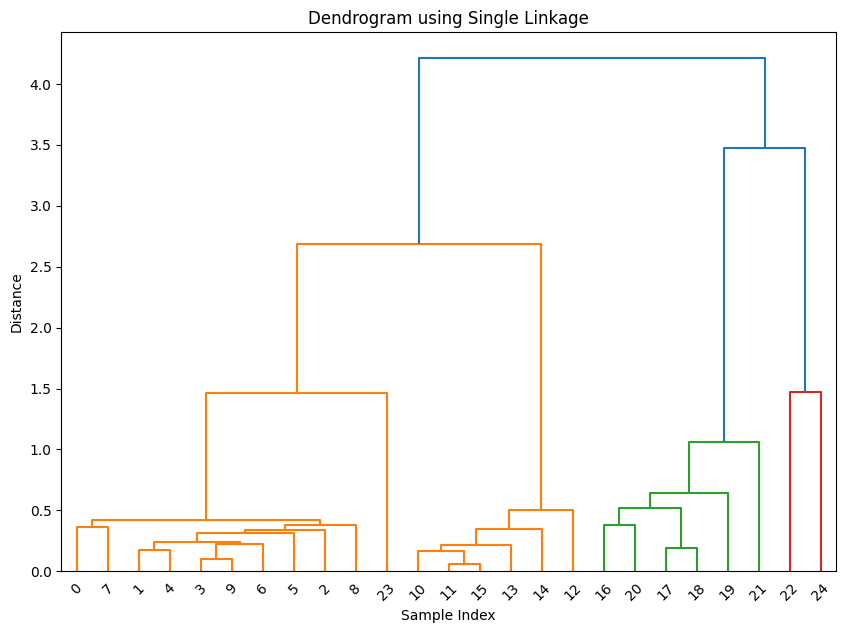

In [41]:
X = new_dataset(20)
# Perform agglomerative clustering
labels =agglo_hier_clust(X, linkage='complete')
plot_dendrogram_and_2d(X, linkage='single')


## Question 16

Use now the scipy implementation of the hierarchical clustering algorithm and visualize the associated dendrogram. How many clusters should you choose inspecting the dendrogram? According to this number of cluster, compute the accuracy of the algorithm

In [42]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [43]:
X, y_true = make_blobs(n_samples=15, centers=3, random_state=42)
Z = linkage(X, method='ward')

In [44]:
Z

array([[10.        , 12.        ,  0.51067098,  2.        ],
       [ 5.        , 13.        ,  0.8518091 ,  2.        ],
       [ 3.        ,  8.        ,  0.86504467,  2.        ],
       [ 4.        ,  6.        ,  0.97563165,  2.        ],
       [ 1.        , 14.        ,  1.00830799,  2.        ],
       [ 7.        , 19.        ,  1.61021529,  3.        ],
       [11.        , 17.        ,  2.11415402,  3.        ],
       [15.        , 18.        ,  2.36175526,  4.        ],
       [ 9.        , 20.        ,  2.55140319,  4.        ],
       [ 2.        , 22.        ,  2.65535389,  5.        ],
       [ 0.        , 23.        ,  3.25828581,  5.        ],
       [16.        , 21.        ,  3.32222376,  5.        ],
       [24.        , 25.        , 22.72542105, 10.        ],
       [26.        , 27.        , 37.3815429 , 15.        ]])

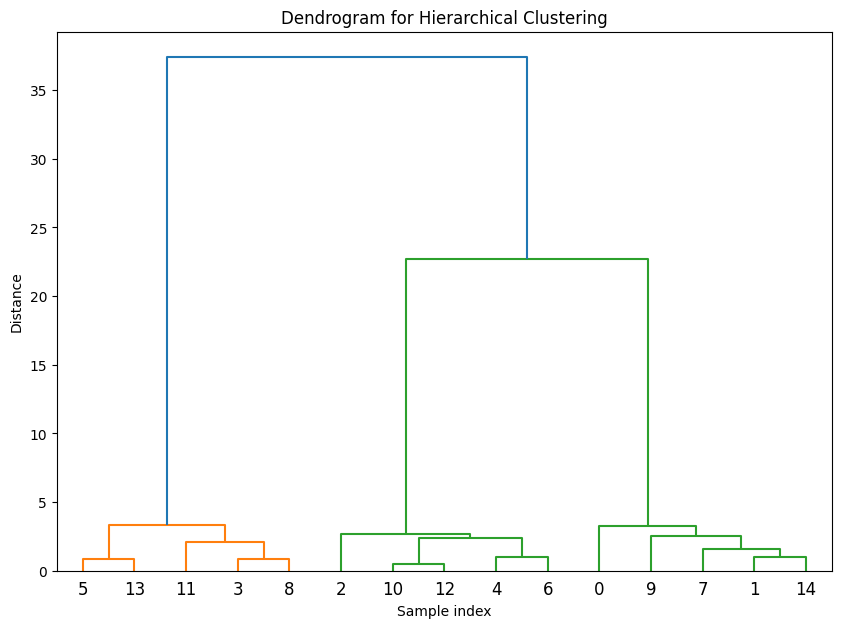

In [45]:
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()

In [46]:
n_clusters = 3
labels = fcluster(Z, n_clusters, criterion='maxclust')

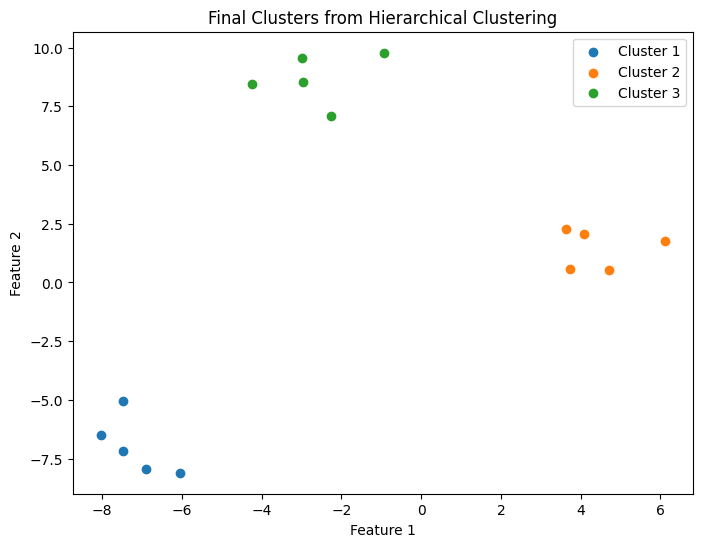

In [47]:
plt.figure(figsize=(8, 6))
for i in range(1, n_clusters + 1):
    plt.scatter(X[labels == i, 0], X[labels == i, 1], label=f"Cluster {i}")
plt.title("Final Clusters from Hierarchical Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

# Part 4: Clustering Algorithms Comparison

## Question 17

- Import three images datasets as we did in previous labs: MNIST, FashionMNIST and CIFAR10. Vectorize these images to have vector input data.

In [89]:
# Use Colab's built-in datasets (faster than downloading)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.flatten())
])

def load_data(dataset_name, samples=1):
    if dataset_name == "MNIST":
        data = torchvision.datasets.MNIST(root='/tmp', train=True, download=True, transform=transform)
    elif dataset_name == "FashionMNIST":
        data = torchvision.datasets.FashionMNIST(root='/tmp', train=True, download=True, transform=transform)
    elif dataset_name == "CIFAR10":
        data = torchvision.datasets.CIFAR10(root='/tmp', train=True, download=True, transform=transform)
        # return data[4][0].permute(1, 2, 0).numpy()
    return data[4][0].numpy().reshape(1, -1)  # Return first image only

# Load data (takes ~5 sec in Colab)
mnist = load_data("MNIST")
fashion = load_data("FashionMNIST")
cifar = load_data("CIFAR10")

# Load data
mnist = load_data("MNIST")
fashion = load_data("FashionMNIST")
cifar = load_data("CIFAR10")



## Question 18

- Perform K-means, Hierarchical clustering and Model-based algorithms (GMM) (you all have seen these algorithms in class). You can use these algorithms from sklearn.

NB: use images of these datasets to perform clustering, keep the labels only to assign performances of your algorithms.

In [53]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

MNIST:


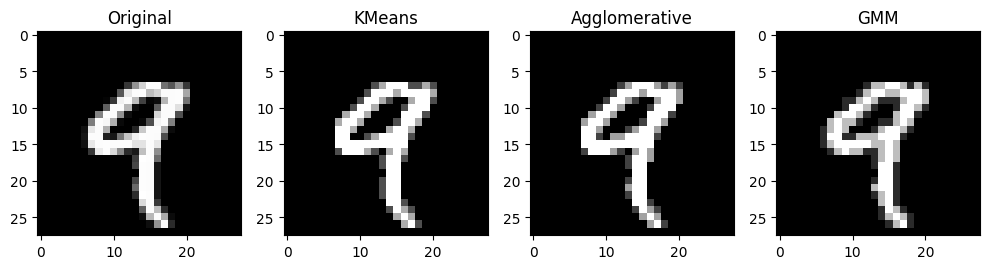

FashionMNIST:


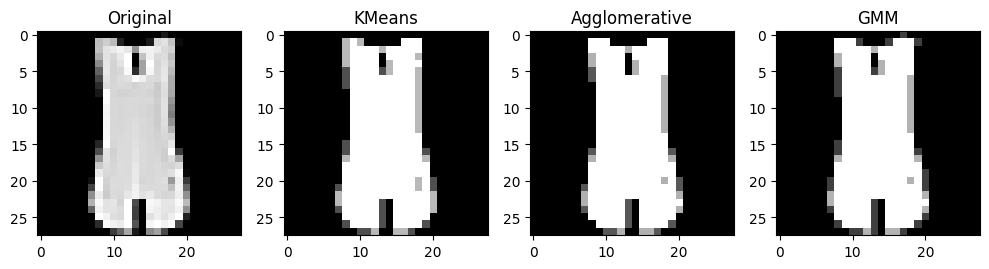

CIFAR10:


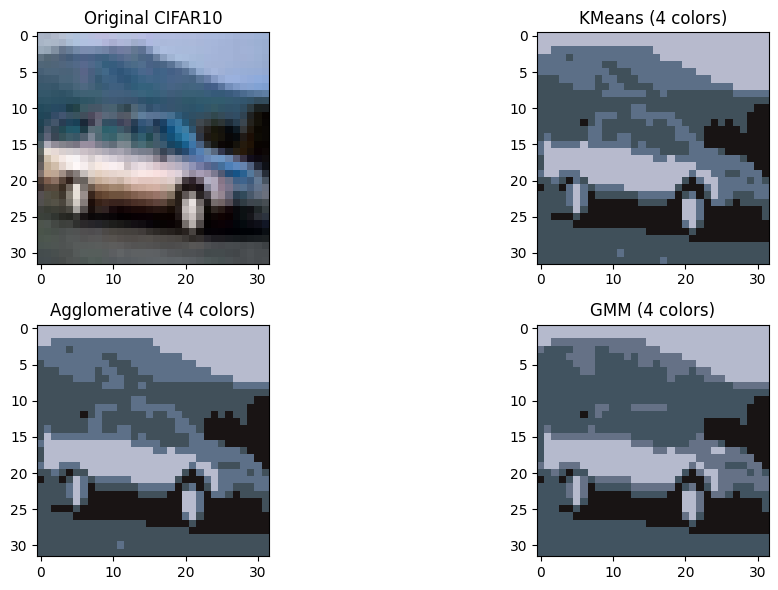

In [90]:
def cluster_compress_mnist(data, n_clusters=4):
    image = data.reshape(28, 28)
    pixels = image.reshape(-1, 1)

    # KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(pixels)
    kmeans_centers = kmeans.cluster_centers_
    kmeans_image = kmeans_centers[kmeans_labels].reshape(28, 28)

    # Agglomerative
    agglo = AgglomerativeClustering(n_clusters=n_clusters)
    agglo_labels = agglo.fit_predict(pixels)
    agglo_centers = np.array([pixels[agglo_labels == i].mean() for i in range(n_clusters)])
    agglo_image = agglo_centers[agglo_labels].reshape(28, 28)

    # GMM
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm_labels = gmm.fit_predict(pixels)
    gmm_centers = gmm.means_
    gmm_image = gmm_centers[gmm_labels].reshape(28, 28)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 4, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Original")

    plt.subplot(1, 4, 2)
    plt.imshow(kmeans_image, cmap='gray')
    plt.title("KMeans")

    plt.subplot(1, 4, 3)
    plt.imshow(agglo_image, cmap='gray')
    plt.title("Agglomerative")

    plt.subplot(1, 4, 4)
    plt.imshow(gmm_image, cmap='gray')
    plt.title("GMM")

    plt.tight_layout()
    plt.show()


def cluster_compress_fashion(data, n_clusters=4):
    image = data.reshape(28, 28)
    pixels = image.reshape(-1, 1)

    # KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(pixels)
    kmeans_centers = kmeans.cluster_centers_
    kmeans_image = kmeans_centers[kmeans_labels].reshape(28, 28)

    # Agglomerative
    agglo = AgglomerativeClustering(n_clusters=n_clusters)
    agglo_labels = agglo.fit_predict(pixels)
    agglo_centers = np.array([pixels[agglo_labels == i].mean() for i in range(n_clusters)])
    agglo_image = agglo_centers[agglo_labels].reshape(28, 28)

    # GMM
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm_labels = gmm.fit_predict(pixels)
    gmm_centers = gmm.means_
    gmm_image = gmm_centers[gmm_labels].reshape(28, 28)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 4, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Original")

    plt.subplot(1, 4, 2)
    plt.imshow(kmeans_image, cmap='gray')
    plt.title("KMeans")

    plt.subplot(1, 4, 3)
    plt.imshow(agglo_image, cmap='gray')
    plt.title("Agglomerative")

    plt.subplot(1, 4, 4)
    plt.imshow(gmm_image, cmap='gray')
    plt.title("GMM")

    plt.tight_layout()
    plt.show()


def cluster_compress_cifar(data, n_clusters=16, sample_pixels=2000):
    #  Reshape image to (H, W, C)
    image = data.reshape(3, 32, 32).transpose(1, 2, 0)  # shape: (32, 32, 3)

    #Ensure float and normalize to [0, 1]
    image = image.astype(np.float32)
    if image.max() > 1.0:
        image /= 255.0

    #  Flatten pixels for clustering
    pixels = image.reshape(-1, 3)

    # Sample subset for faster clustering
    np.random.seed(42)
    sample_indices = np.random.choice(len(pixels), min(sample_pixels, len(pixels)), replace=False)
    pixel_subset = pixels[sample_indices]

    # KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(pixel_subset)
    kmeans_labels = kmeans.predict(pixels)
    kmeans_centers = kmeans.cluster_centers_
    kmeans_img = kmeans_centers[kmeans_labels].reshape(32, 32, 3)

    # Agglomerative
    agg = AgglomerativeClustering(n_clusters=n_clusters)
    agg_labels_subset = agg.fit_predict(pixel_subset)
    agg_centers = np.array([pixel_subset[agg_labels_subset == i].mean(axis=0) for i in range(n_clusters)])
    dists = np.linalg.norm(pixels[:, None] - agg_centers[None, :], axis=2)
    agg_labels = np.argmin(dists, axis=1)
    agg_img = agg_centers[agg_labels].reshape(32, 32, 3)

    #  GMM
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(pixel_subset)
    gmm_labels = gmm.predict(pixels)
    gmm_centers = gmm.means_
    gmm_img = gmm_centers[gmm_labels].reshape(32, 32, 3)

    # Clip and show images
    def clip_img(x):
        return np.clip(x, 0, 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(2, 2, 1)
    plt.imshow(clip_img(image))
    plt.title("Original CIFAR10")

    plt.subplot(2, 2, 2)
    plt.imshow(clip_img(kmeans_img))
    plt.title(f"KMeans ({n_clusters} colors)")

    plt.subplot(2, 2, 3)
    plt.imshow(clip_img(agg_img))
    plt.title(f"Agglomerative ({n_clusters} colors)")

    plt.subplot(2, 2, 4)
    plt.imshow(clip_img(gmm_img))
    plt.title(f"GMM ({n_clusters} colors)")

    plt.tight_layout()
    plt.show()

print("MNIST:")
cluster_compress_mnist(load_data("MNIST"), n_clusters=4)

print("FashionMNIST:")
cluster_compress_fashion(load_data("FashionMNIST"), n_clusters=4)

print("CIFAR10:")
cluster_compress_cifar(load_data("CIFAR10"), n_clusters=4)


## Question 19

Asses the performance of each algorithm.

On each dataset, describe what you observe. Overall, is there any algorithms that is better? If yes, why?

GMM performs best overall, preserving gradients and textures across all datasets. KMeans also gives good results but with harsher transitions. Agglomerative tends to produce blockier outputs, especially on complex images like CIFAR-10. GMM’s probabilistic modeling makes it more effective for smooth image compression.

## Question 20

List pros and cons of each algorithms from what you have seen during the lab.

### Pros and Cons of Clustering Algorithms

#### KMeans
**Pros:**
- Fast and scalable
- Preserves structure reasonably well

**Cons:**
- Hard edges, less smoothness
- Assumes spherical clusters

#### Agglomerative (Hierarchical)
**Pros:**
- Captures local similarities
- Doesn’t assume cluster shape

**Cons:**
- Slower for larger datasets
- Produces blocky and less detailed images

#### GMM (Gaussian Mixture Model)
**Pros:**
- Smooth results, captures variation well
- Probabilistic: better for soft boundaries

**Cons:**
- Slower than KMeans
- Can be sensitive to initialization
